In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('VGS_clean.csv')

In [12]:
df['year'] = df['year'].apply(lambda s:str(s)[:-2])
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['year'], format="%Y")).year
df.set_index('year', inplace=True)
df.sort_values(by='year', inplace=True)

In [13]:
y = df['global_sales']

In [14]:
y = pd.pivot_table(df ,index = "year" ,
                                       values = "global_sales",
                                       aggfunc = np.sum)

<AxesSubplot:xlabel='year'>

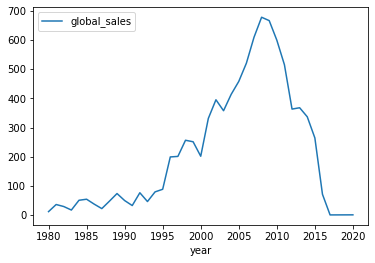

In [15]:
y.plot()

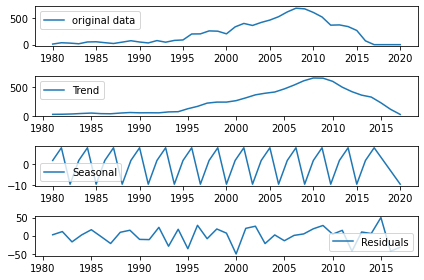

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y, freq=3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'original data')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [17]:
from statsmodels.tsa.stattools import kpss
kpss(y)

(0.2843899772458229,
 0.1,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

<AxesSubplot:xlabel='year'>

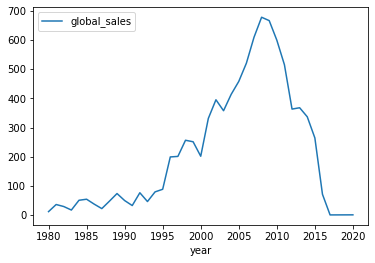

In [18]:
y.plot()

<AxesSubplot:xlabel='year'>

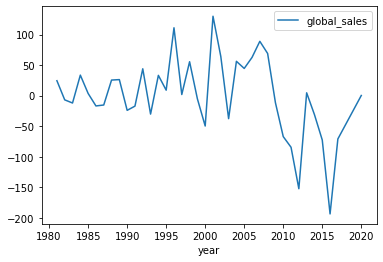

In [19]:
y_diff=y.diff().dropna()
y_diff.plot()

In [20]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [21]:
def evaluate_arima_model(df, arima_order):
    split=int(len(df) * 0.8) 
    train, test = df[0:split], df[split:len(df)]
    past=[x for x in train]
    predictions = list()
    for i in range(len(test)): 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    error = mean_squared_error(test, predictions)
    return error

In [22]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [23]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [24]:
evaluate_models(y.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=33881.445
ARIMA(0, 0, 1) MSE=11434.289
ARIMA(0, 1, 0) MSE=11671.704
ARIMA(0, 1, 1) MSE=9651.445
ARIMA(0, 1, 2) MSE=10128.090
ARIMA(0, 2, 0) MSE=8699.355
ARIMA(0, 2, 1) MSE=11417.974
ARIMA(0, 2, 2) MSE=13212.952
ARIMA(1, 0, 0) MSE=9326.917
ARIMA(1, 0, 1) MSE=7305.516
ARIMA(1, 0, 2) MSE=7327.708
ARIMA(1, 1, 0) MSE=9550.339
ARIMA(1, 1, 1) MSE=9781.435
ARIMA(1, 2, 0) MSE=8924.886
ARIMA(1, 2, 1) MSE=11292.562
ARIMA(2, 0, 0) MSE=7065.706
ARIMA(2, 1, 0) MSE=10239.808
ARIMA(2, 1, 1) MSE=9820.388
ARIMA(2, 2, 0) MSE=8806.349
ARIMA(2, 2, 1) MSE=13297.726
Best ARIMA(2, 0, 0) MSE=7065.706


In [25]:
p=2
d=0
q=0
model = ARIMA(y, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(5)

In [26]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           global_sales   No. Observations:                   39
Model:                     ARMA(2, 0)   Log Likelihood                -214.352
Method:                       css-mle   S.D. of innovations             56.920
Date:                Fri, 06 Aug 2021   AIC                            436.703
Time:                        12:31:45   BIC                            443.358
Sample:                             0   HQIC                           439.091
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                157.4110    125.142      1.258      0.208     -87.863     402.685
ar.L1.global_sales     1.3409      0.142      9.446      0.000       1.063       1.619
ar.L2.global_sales    -0.4048      0.144     -2.811      0.005      -0.687      -0.123
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1340           +0.0000j            1.1340            0.0000
AR.2            2.1785           +0.0000j            2.1785            0.0000
-----------------------------------------------------------------------------
"""

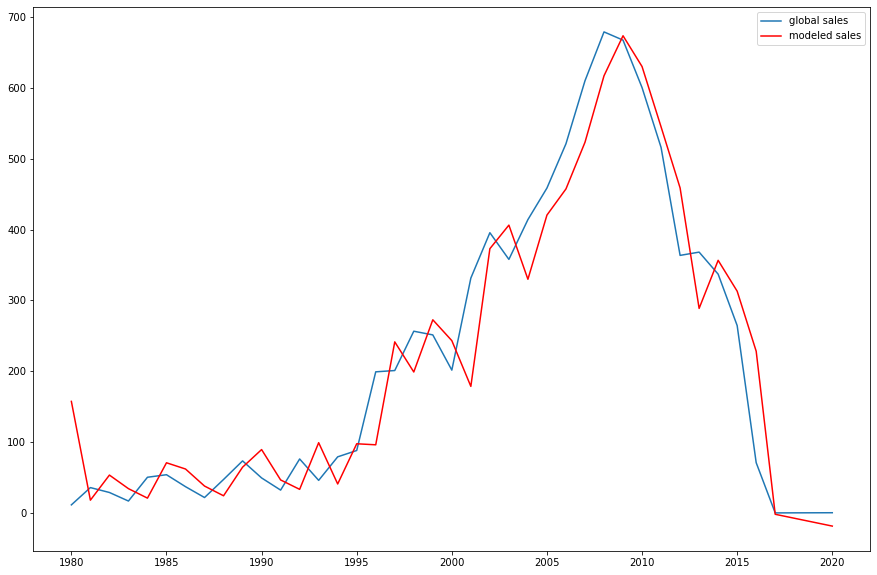

In [30]:
plt.figure(figsize=(15,10))
plt.plot(y, label = 'global sales')
plt.plot(model_fit.predict(), color = 'red', label = 'modeled sales')
plt.legend(loc = 'best')

In [19]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period= 5
date_range = pd.date_range(str(y.index[-1]), periods = forecast_period, 
              freq='Y').strftime("%Y").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_years = pd.DataFrame(date_range, columns = ['year'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_years['year'] = pd.to_datetime(future_years['year']).dt.year
future_years.set_index('year', inplace = True)

future_years['Prediction'] = pd.Series(forecast[0]).values

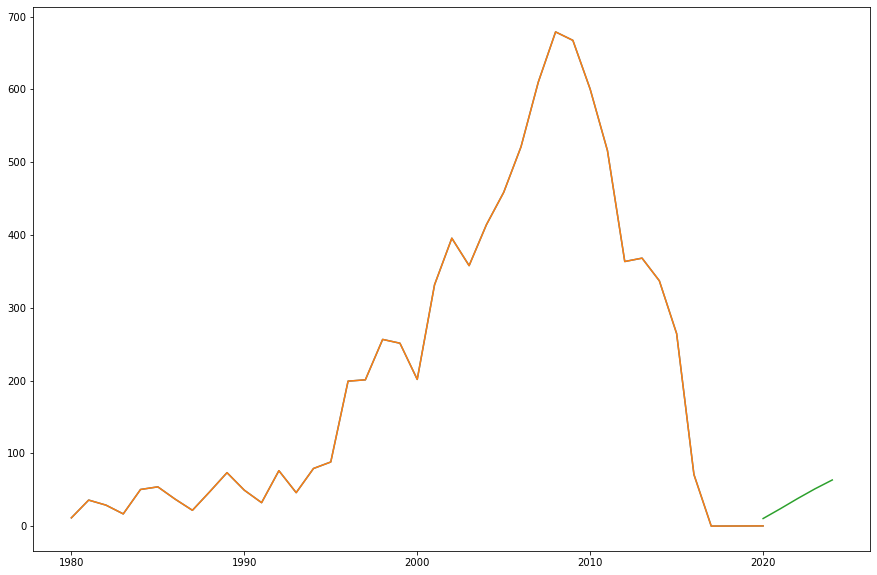

No handles with labels found to put in legend.


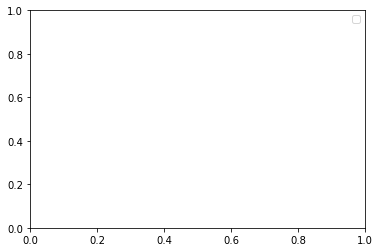

In [32]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period= 5
date_range = pd.date_range(str(y.index[-1]), periods = forecast_period, 
              freq='Y').strftime("%Y").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_years = pd.DataFrame(date_range, columns = ['year'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_years['year'] = pd.to_datetime(future_years['year']).dt.year
future_years.set_index('year', inplace = True)

future_years['Prediction'] = pd.Series(forecast[0]).values

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y, label = 'past sales')
plt.plot(y.append(future_years), label = 'forecast')
plt.show()
plt.legend(loc = 'best')

In [21]:
returns = y.pct_change()

In [102]:
returns[1:]

,global_sales
year,
1981,2.143234
1982,-0.193179
1983,-0.418226
1984,1.999404
1985,0.071088
1986,-0.312755
1987,-0.413542
1988,1.172033
1989,0.555485


In [22]:
autocorrelation = returns['global_sales'].autocorr()

In [23]:
print("The autocorrelation of annual returns is %4.2f" %(autocorrelation))

The autocorrelation of annual returns is -0.30


In [24]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

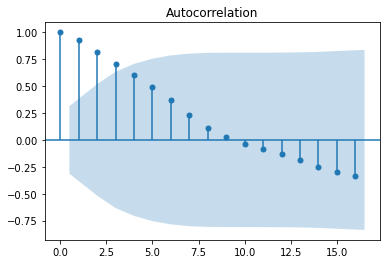

In [73]:
plot_acf(y)
pyplot.show()

In [74]:
from matplotlib import pyplot
from arch import arch_model
import datetime as dt

In [75]:
# split into train/test
split_date = dt.datetime(2008,1,1).year

In [95]:
y[:29]

,global_sales
year,
1980,11.38
1981,35.77
1982,28.86
1983,16.79
1984,50.36
1985,53.94
1986,37.07
1987,21.74
1988,47.22


In [112]:
# define model
model = arch_model(y, mean='Constant', vol='ARCH', p=4)

In [113]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 256.8517007399319
Iteration:      2,   Func. Count:     15,   Neg. LLF: 256.6360695984028
Iteration:      3,   Func. Count:     22,   Neg. LLF: 256.5886827603254
Iteration:      4,   Func. Count:     29,   Neg. LLF: 256.56809272244664
Iteration:      5,   Func. Count:     36,   Neg. LLF: 256.56538577342513
Iteration:      6,   Func. Count:     43,   Neg. LLF: 256.5505133501008
Iteration:      7,   Func. Count:     50,   Neg. LLF: 256.52474135258126
Iteration:      8,   Func. Count:     57,   Neg. LLF: 256.43786391085564
Iteration:      9,   Func. Count:     64,   Neg. LLF: 256.22440204643533
Iteration:     10,   Func. Count:     71,   Neg. LLF: 255.5817716703597
Iteration:     11,   Func. Count:     78,   Neg. LLF: 253.5507478307566
Iteration:     12,   Func. Count:     85,   Neg. LLF: 251.50758016944627
Iteration:     13,   Func. Count:     92,   Neg. LLF: 250.93276190382235
Iteration:     14,   Func. Count:     99,   Neg. LLF: 251

In [114]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:           global_sales   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -250.606
Distribution:                  Normal   AIC:                           513.212
Method:            Maximum Likelihood   BIC:                           523.194
                                        No. Observations:                   39
Date:                Tue, Aug 03 2021   Df Residuals:                       38
Time:                        12:44:30   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            70.9273     62.972      1.126      0.260 [-52.496,1.944e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega       8767.0615  1.763e+04      0.497      0.619 [-2.579e+04,4.333e+04]
alpha[1]       0.8203      2.767      0.296      0.767      [ -4.604,  6.244]
alpha[2]   6.4765e-13      2.666  2.429e-13      1.000      [ -5.225,  5.225]
alpha[3]   7.4023e-13      2.718  2.723e-13      1.000      [ -5.328,  5.328]
alpha[4]   9.2599e-13      2.825  3.278e-13      1.000      [ -5.537,  5.537]
=============================================================================

Covariance estimator: robust
"""

In [117]:
# define model
model = arch_model(y, mean='Constant', vol='GARCH', p=4)

In [118]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 259.67836217651114
Iteration:      2,   Func. Count:     17,   Neg. LLF: 259.1027518561166
Iteration:      3,   Func. Count:     25,   Neg. LLF: 263.0426682507778
Iteration:      4,   Func. Count:     34,   Neg. LLF: 258.84812659779607
Iteration:      5,   Func. Count:     43,   Neg. LLF: 258.57735665819916
Iteration:      6,   Func. Count:     51,   Neg. LLF: 258.5751636532402
Iteration:      7,   Func. Count:     59,   Neg. LLF: 258.5705398462066
Iteration:      8,   Func. Count:     67,   Neg. LLF: 258.55488255895244
Iteration:      9,   Func. Count:     75,   Neg. LLF: 258.51867175551354
Iteration:     10,   Func. Count:     83,   Neg. LLF: 258.42830728153797
Iteration:     11,   Func. Count:     91,   Neg. LLF: 258.2279833722091
Iteration:     12,   Func. Count:     99,   Neg. LLF: 257.8442402478204
Iteration:     13,   Func. Count:    107,   Neg. LLF: 257.25851987312564
Iteration:     14,   Func. Count:    115,   Neg. LLF: 256

In [119]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           global_sales   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -256.305
Distribution:                  Normal   AIC:                           526.610
Method:            Maximum Likelihood   BIC:                           538.255
                                        No. Observations:                   39
Date:                Tue, Aug 03 2021   Df Residuals:                       38
Time:                        12:44:41   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           119.7114    109.117      1.097      0.273 [-94.155,3.336e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1918e+04   6384.943      3.433  5.973e-04 [9.404e+03,3.443e+04]
alpha[1]       0.5905      0.282      2.097  3.598e-02   [3.862e-02,  1.142]
alpha[2]   6.6848e-14      3.009  2.222e-14      1.000     [ -5.897,  5.897]
alpha[3]   7.8082e-14      4.321  1.807e-14      1.000     [ -8.469,  8.469]
alpha[4]   1.0041e-13      2.428  4.136e-14      1.000     [ -4.759,  4.759]
beta[1]    2.0247e-13      0.878  2.306e-13      1.000     [ -1.721,  1.721]
============================================================================

Covariance estimator: robust
"""